<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install dataretrieval
import glob
import os
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from shapely import Point
from scipy.stats import linregress

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Pair gage ids with effective width point ids

In [237]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,06620000,41900,140.711919
1,06620000,41913,142.907272
2,06620000,41930,86.932041
3,06775900,93932,96.207959
4,06775900,94005,140.444539
5,06775900,94011,72.135208
6,06800000,120445,76.595306
7,06800000,120725,148.276448
8,06800000,120748,64.253559
9,06801000,153085,2096.250518


Load gages for 27 gage validation

In [ ]:
gage_pts = gpd.read_file('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_2.shp')[['iindex', 'site_no']]
gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250918.shp'), how='outer', on='iindex')[['site_no', 'iindex', 'riv_length']]
gage_list = gage_pts.site_no.tolist()
gage_pts

,site_no,iindex,riv_length
0,06797500,11750,286.834439
1,06799315,27910,520.411858
2,06759500,30618,324.754737
3,06721000,35136,66.485390
4,06711565,38194,116.262817
5,06710247,38526,86.358781
6,06714215,41178,191.552417
7,06620000,41900,140.711919
8,06652000,57498,419.438461
9,06785500,64575,285.088443


Load in-situ widths from USGS

In [244]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']].set_index(['site_no', 'date'])
isw

gage_width_m
site_no  date                    
06775900 2021-05-26     15.853659
         2016-11-16     11.585366
         2016-08-17     11.585366
         2017-06-14     15.853659
         2019-08-21     14.024390
...                           ...
06805500 2025-07-16    378.048780
         2025-08-12    378.048780
         2025-08-27    378.048780
         2025-07-31    378.048780
         2025-08-12    378.048780

[1237 rows x 1 columns]

Discharge

In [246]:
# sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']
sites = gage_list

# first and last dates same as for in situ widths
start = str(isw.index.sortlevel(1)[0][0][1])
end = str(isw.index.sortlevel(1)[0][-1][1])

Q = nwis.get_record(sites, service='dv', start=start, end=end).reset_index()
Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean', '00060_Mean_cd', '00065_Mean', '00065_Mean_cd']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q['00065_Mean'] = Q['00065_Mean'] * (3.28 ** -1)
Q = Q.rename(columns={'00060_Mean': 'Q_cms', '00060_Mean_cd': 'Q_cd', '00065_Mean': 'd_m', '00065_Mean_cd': 'd_cd'})
Q = Q.set_index(['site_no', 'date'])
Q

Q_cms  Q_cd       d_m d_cd
site_no  date                                       
06620000 2007-11-19    3.967405     A       NaN  NaN
         2007-11-20    3.740696     A       NaN  NaN
         2007-11-21    3.485648  A, e       NaN  NaN
         2007-11-22    3.230601  A, e       NaN  NaN
         2007-11-23    2.862199  A, e       NaN  NaN
...                         ...   ...       ...  ...
06805500 2025-09-18  244.278776     P  1.143293    P
         2025-09-19  273.184153     P  1.198171    P
         2025-09-20  267.799818     P  1.189024    P
         2025-09-21  294.721493     P  1.237805    P
         2025-09-22  265.249343     P  1.185976    P

[39108 rows x 4 columns]

Join in-situ width and discharge to build rating curves

In [247]:
cotemporal_wQ = Q.join(isw, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

Q_cms  Q_cd       d_m d_cd  gage_width_m      logw  \
site_no  date                                                                  
06620000 2011-08-22   11.392119     A       NaN  NaN     46.951220  1.671647   
         2011-10-12    6.206155     A       NaN  NaN     46.951220  1.671647   
         2012-01-30    3.825712  A, e       NaN  NaN     39.634146  1.598070   
         2012-03-30   17.173195     A       NaN  NaN     47.865854  1.680026   
         2012-06-22    4.279129     A       NaN  NaN     37.804878  1.577548   
...                         ...   ...       ...  ...           ...       ...   
06805500 2025-07-16  250.229883     P  1.161585    P    378.048780  2.577548   
         2025-07-31  368.401866     P  1.329268    P    378.048780  2.577548   
         2025-08-12  253.347129     P  1.164634    P    378.048780  2.577548   
         2025-08-12  253.347129     P  1.164634    P    378.048780  2.577548   
         2025-08-27  121.856002     P  0.865854    P    378.048780  2.577548   

                         logQ  
site_no  date                  
06620000 2011-08-22  1.056605  
         2011-10-12  0.792823  
         2012-01-30  0.582712  
         2012-03-30  1.234851  
         2012-06-22  0.631355  
...                       ...  
06805500 2025-07-16  2.398339  
         2025-07-31  2.566322  
         2025-08-12  2.403716  
         2025-08-12  2.403716  
         2025-08-27  2.085847  

[1222 rows x 7 columns]

Text(0.02, 0.5, 'Gage width (m)')

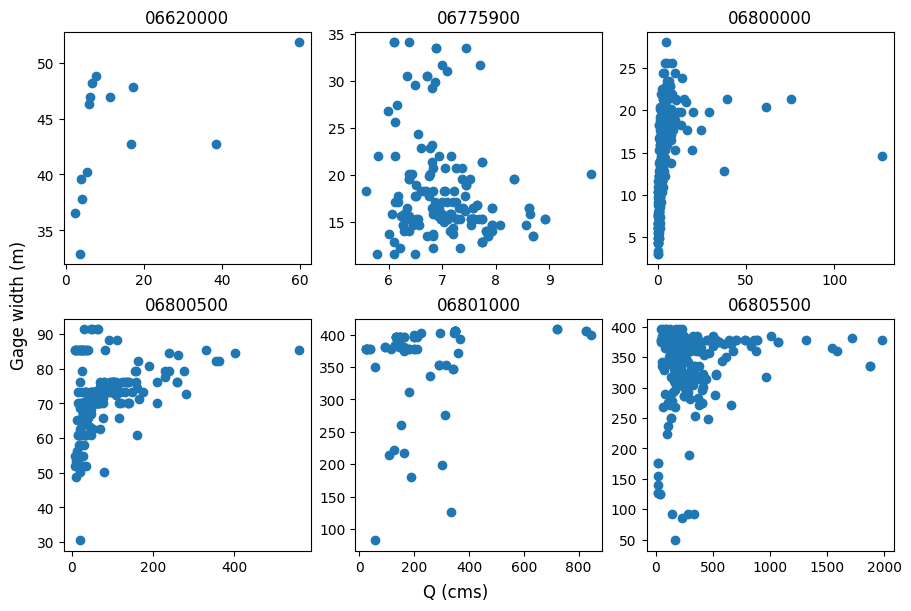

In [248]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.gage_width_m)
    ax.set_title(sn)
    p += 1

fig.supxlabel('Q (cms)')
fig.supylabel('Gage width (m)')

Build power law rating curves with cotemporal gage w and Q

Text(0.5, 0.98, 'Power law w/Q rating curves')

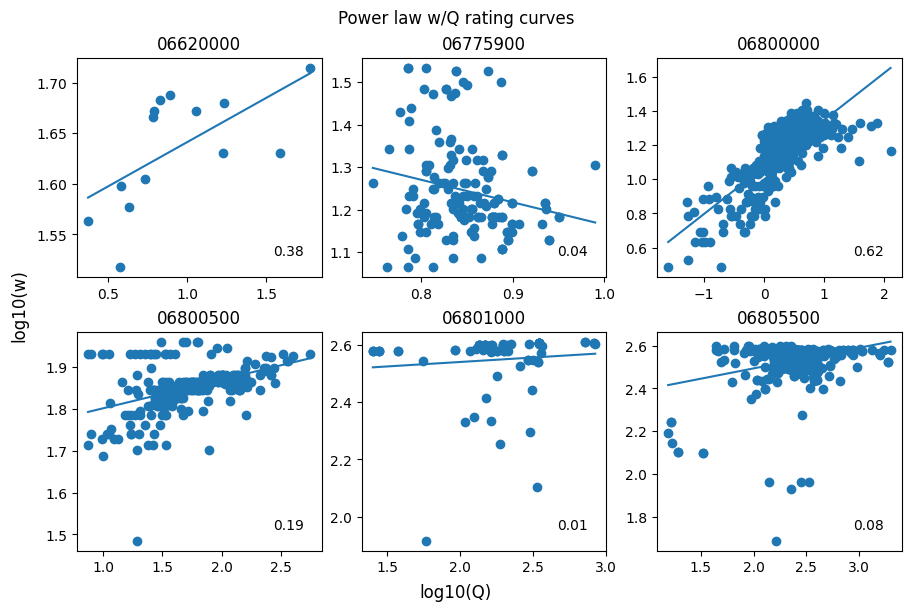

In [249]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)
p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):

    slope, intercept, r, pval, _ = linregress(df.logQ, df.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    ax.scatter(df.logQ, df.logw)
    ax.set_title(sn)
    rc_x = np.linspace(min(df.logQ), max(df.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.supxlabel('log10(Q)')
fig.supylabel('log10(w)')
fig.suptitle('Power law w/Q rating curves')

In [250]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06775900,0.087846,1.553382,0.383412,35.758761
06800500,-0.528364,1.692555,0.042450,49.266824
06800000,0.275465,1.072609,0.616782,11.819760
06620000,0.068638,1.732994,0.186642,54.074626
06801000,0.031141,2.477969,0.008993,300.585898
06805500,0.096246,2.301079,0.079128,200.022788


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [251]:
def est_width(row, site_no):
    a = rating_curve_parms.loc[site_no, 'a']
    b = rating_curve_parms.loc[site_no, 'b']
    Q = row['Q_cms']

    return a * (Q ** b)

Q['rc_width_m'] = Q.apply(lambda row: est_width(row, row.name[0]), axis=1)
Q = Q.join(isw, how='outer', on=['site_no', 'date'])
Q

Q_cms  Q_cd       d_m d_cd  rc_width_m  gage_width_m
site_no  date                                                                 
06620000 2007-11-19    3.967405     A       NaN  NaN   59.439310           NaN
         2007-11-20    3.740696     A       NaN  NaN   59.199738           NaN
         2007-11-21    3.485648  A, e       NaN  NaN   58.913488           NaN
         2007-11-22    3.230601  A, e       NaN  NaN   58.607024           NaN
         2007-11-23    2.862199  A, e       NaN  NaN   58.121987           NaN
...                         ...   ...       ...  ...         ...           ...
06805500 2025-09-18  244.278776     P  1.143293    P  339.550623           NaN
         2025-09-19  273.184153     P  1.198171    P  343.225218           NaN
         2025-09-20  267.799818     P  1.189024    P  342.568258           NaN
         2025-09-21  294.721493     P  1.237805    P  345.741181           NaN
         2025-09-22  265.249343     P  1.185976    P  342.252890           NaN

[39304 rows x 6 columns]

Text(0.5, 0.98, 'Rating curve validation')

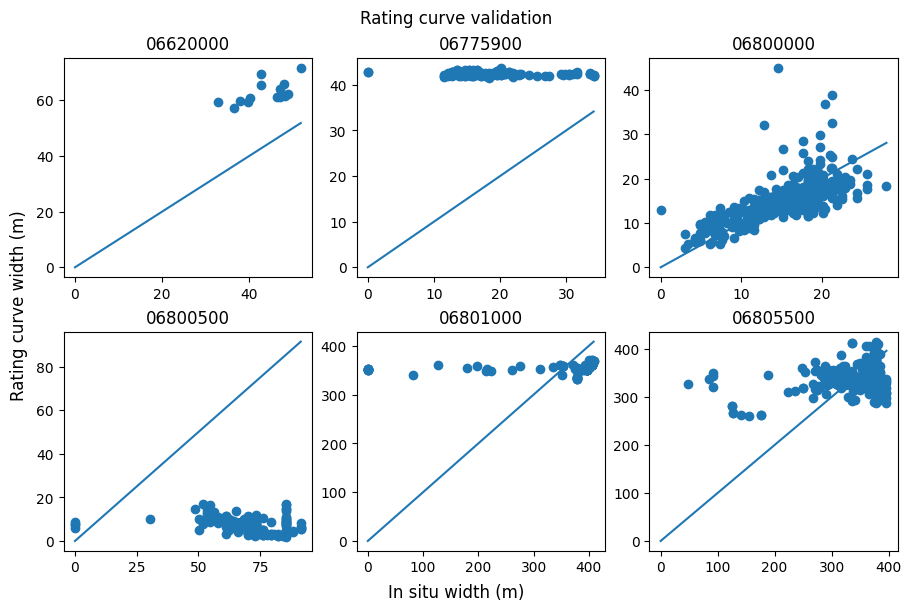

In [254]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in Q.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.rc_width_m)
    unity = np.linspace(0, (df.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    ax.set_title(sn)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    p += 1

fig.supxlabel('In situ width (m)')
fig.supylabel('Rating curve width (m)')
fig.suptitle('Rating curve validation')

Load in effective width\
See stac_processing_download.ipynb

In [97]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    # width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_g2_20250921.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[(allwidths.n_valid == allwidths.n_pixels) & (allwidths.n_valid > -999)]


nondup_widths = allwidths
allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,2063,S2B_14TMM_20240511_0_L2A,68202,2169,2169,444,3,0,2,151,24,14TMM,2024-05-11,0
2064,2064,S2B_13TGF_20240716_0_L2A,225467,162,162,84,0,0,0,43,12,13TGF,2024-07-16,0
2065,2065,S2A_14TPL_20241013_0_L2A,115317,4949,4949,1038,0,0,0,228,27,14TPL,2024-10-13,0
2066,2066,S2A_14TKL_20240728_0_L2A,225467,161,161,98,0,0,0,42,16,14TKL,2024-07-28,0


In [221]:
allwidths.loc[allwidths.iindex == 41178]

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version
8,8,S2B_13TDE_20181029_0_L2A,41178,254,254,54,0,0,0,54,3,13TDE,2018-10-29,0
66,66,S2B_13TDE_20180926_1_L2A,41178,254,254,39,0,0,0,54,2,13TDE,2018-09-26,1
79,79,S2B_13TDE_20180303_1_L2A,41178,254,254,9,0,0,0,54,1,13TDE,2018-03-03,1
87,87,S2A_13TDE_20181223_0_L2A,41178,254,254,10,63,0,0,54,2,13TDE,2018-12-23,0
90,90,S2A_13TDE_20180716_1_L2A,41178,254,254,33,0,0,0,54,4,13TDE,2018-07-16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,1940,S2A_13TEE_20240704_0_L2A,41178,254,254,46,0,0,0,54,4,13TEE,2024-07-04,0
1946,1946,S2B_13TEE_20240924_0_L2A,41178,254,254,39,21,0,0,54,3,13TEE,2024-09-24,0
2020,2020,S2A_13TEE_20240425_0_L2A,41178,254,254,33,0,0,0,54,3,13TEE,2024-04-25,0
2023,2023,S2A_13TEE_20240601_0_L2A,41178,254,254,46,7,0,0,54,5,13TEE,2024-06-01,0


AWS S2 STAC holds duplicate versions of some images with different versions of the processing baseline. Identify tiles and dates with multiple images and select the one with the most up to date processing baseline.

In [ ]:
tile_dts = []
tile_dt_versions = []
for row in tqdm(allwidths.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))

tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version']).sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = (temp_df.head(1))
    nonduplicates.append(df_out)


nonduplicates = pd.concat(nonduplicates)
nonduplicates

13598it [00:00, 22137.28it/s]
100%|██████████| 2304/2304 [00:05<00:00, 393.94it/s]


,index,mgrs,date,version
0,178,14TPM,2023-04-07,0
0,321,15TTG,2019-08-28,1
0,1822,14TPM,2018-06-29,0
0,1939,14TQL,2024-10-25,0
0,684,14TQM,2021-12-30,1
...,...,...,...,...
0,361,14TLM,2021-07-09,0
0,2719,13TCF,2019-08-25,1
0,3044,14TPM,2022-04-14,0
0,1677,14TQL,2020-08-27,1


Join nonduplicate images with widths and gage ids

In [98]:
# nondup_widths = pd.merge(allwidths, nonduplicates[['mgrs', 'date', 'version']], 'right', on=['mgrs', 'date', 'version'])
nondup_widths = pd.merge(nondup_widths, gage_pts, how='left', on='iindex')
nondup_widths = nondup_widths.rename(columns={'gage_id': 'site_no'})
nondup_widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version,site_no,riv_length
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1,06764880,172.516752
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0,06800000,148.276448
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1,06635000,93.794831
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1,06630000,480.468419
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1,06797500,286.834439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12284,2063,S2B_14TMM_20240511_0_L2A,68202,2169,2169,444,3,0,2,151,24,14TMM,2024-05-11,0,06777495,573.022347
12285,2064,S2B_13TGF_20240716_0_L2A,225467,162,162,84,0,0,0,43,12,13TGF,2024-07-16,0,06764880,172.516752
12286,2065,S2A_14TPL_20241013_0_L2A,115317,4949,4949,1038,0,0,0,228,27,14TPL,2024-10-13,0,06793000,1341.859239
12287,2066,S2A_14TKL_20240728_0_L2A,225467,161,161,98,0,0,0,42,16,14TKL,2024-07-28,0,06764880,172.516752


In [ ]:
nondup_widths.columns

Index(['Unnamed: 0', 'img_id', 'iindex', 'n_pixels', 'n_valid', 'n_river',
       'n_cloud', 'n_snow', 'n_cloudriver', 'n_edge', 'n_edgeriver', 'mgrs',
       'version', 'riv_length', 'sat_width_m', 'fraction_cloud',
       'fraction_snow', 'agency_cd', 'site_no', 'station_nm', 'site_tp_cd',
       'dec_lat_va', 'dec_long_v', 'coord_acy_', 'dec_coord_', 'alt_va',
       'alt_acy_va', 'alt_datum_', 'huc_cd', 'index_righ', 'geometry'],
      dtype='object')

Calculate effective width and fractions of cloud and snow

In [99]:
nondup_widths['sat_width_m'] = nondup_widths.n_river * 100 / nondup_widths.riv_length
nondup_widths['fraction_cloud'] = nondup_widths.n_cloud / nondup_widths.n_pixels
nondup_widths['fraction_snow'] = nondup_widths.n_snow / nondup_widths.n_pixels
nondup_widths['fraction_edgeriver'] = nondup_widths.n_edgeriver / nondup_widths.n_edge
nondup_widths = nondup_widths.set_index(['site_no', 'date'])
nondup_widths

,,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,version,riv_length,sat_width_m,fraction_cloud,fraction_snow,fraction_edgeriver
site_no,date,,,,,,,,,,,,,,,,,,
06764880,2018-06-23,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,1,172.516752,39.996116,0.000000,0.0,0.209302
06800000,2018-10-15,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,0,148.276448,18.209230,0.024390,0.0,0.093023
06635000,2018-06-11,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,1,93.794831,13.860039,0.000000,0.0,0.133333
06630000,2018-06-11,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,1,480.468419,31.635794,0.069388,0.0,0.060870
06797500,2018-06-22,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,1,286.834439,25.101588,0.443548,0.0,0.040541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06777495,2024-05-11,2063,S2B_14TMM_20240511_0_L2A,68202,2169,2169,444,3,0,2,151,24,14TMM,0,573.022347,77.483889,0.001383,0.0,0.158940
06764880,2024-07-16,2064,S2B_13TGF_20240716_0_L2A,225467,162,162,84,0,0,0,43,12,13TGF,0,172.516752,48.690924,0.000000,0.0,0.279070
06793000,2024-10-13,2065,S2A_14TPL_20241013_0_L2A,115317,4949,4949,1038,0,0,0,228,27,14TPL,0,1341.859239,77.355357,0.000000,0.0,0.118421


Import likes and dislikes from river tinder

In [ ]:

def flatten(xss):
    return [x for xs in xss for x in xs]



checked_img_path = '/content/drive/MyDrive/effwidth_results/rt_likes_dislikes'
lols = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'likes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lols.append(lines)

lods = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'dislikes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lods.append(lines)


lols = flatten(lols)
lods = flatten(lods)

lds = pd.DataFrame({'name': lols + lods})
lds['iindex'] = lds.apply(lambda x: int(x['name'][25:]), axis=1)
lds['img_id'] = lds.apply(lambda x: str(x['name'][0:24]), axis=1)
lds['like'] = (np.concatenate([np.repeat(True, len(lols)), np.repeat(False, len(lods))], axis=0))

lds

100%|██████████| 28/28 [00:00<00:00, 212.21it/s]


,name,iindex,img_id,like
0,S2A_14TQL_20240930_0_L2A_201625,201625,S2A_14TQL_20240930_0_L2A,True
1,S2A_15TTF_20240930_0_L2A_153085,153085,S2A_15TTF_20240930_0_L2A,True
2,S2A_15TTF_20240930_0_L2A_202726,202726,S2A_15TTF_20240930_0_L2A,True
3,S2A_15TTF_20240930_0_L2A_203066,203066,S2A_15TTF_20240930_0_L2A,True
4,S2A_15TTF_20240930_0_L2A_202446,202446,S2A_15TTF_20240930_0_L2A,True
...,...,...,...,...
1691,S2A_14TQL_20240913_0_L2A_202726,202726,S2A_14TQL_20240913_0_L2A,False
1692,S2A_14TQL_20240913_0_L2A_203066,203066,S2A_14TQL_20240913_0_L2A,False
1693,S2A_14TQL_20240913_0_L2A_202446,202446,S2A_14TQL_20240913_0_L2A,False
1694,S2A_14TQL_20240913_0_L2A_201888,201888,S2A_14TQL_20240913_0_L2A,False


Join rating curve width, gage width, and sat width on date

In [100]:
alldata = Q.join(nondup_widths, how='outer').reset_index()
# alldata = pd.merge(alldata, lds, how='outer',  on=['img_id', 'iindex'])
alldata = alldata.set_index(['site_no', 'date'])
alldata

Q_cms  Q_cd       d_m d_cd  Unnamed: 0  \
site_no  date                                                    
06620000 2018-01-01  3.740696  A, e       NaN  NaN         NaN   
         2018-01-02  3.457310  A, e       NaN  NaN       632.0   
         2018-01-03  3.343955  A, e       NaN  NaN         NaN   
         2018-01-04  3.400633  A, e       NaN  NaN         NaN   
         2018-01-05  3.513987  A, e       NaN  NaN         NaN   
...                       ...   ...       ...  ...         ...   
06800000 2024-12-27  0.793481     A  0.725610    A         NaN   
         2024-12-28  0.816152     A  0.728659    A         NaN   
         2024-12-29  0.864327     A  0.734756    A      1559.0   
         2024-12-30  0.872829     A  0.734756    A         NaN   
         2024-12-31  0.838823     A  0.731707    A         NaN   

                                       img_id    iindex  n_pixels  n_valid  \
site_no  date                                                                
06620000 2018-01-01                       NaN       NaN       NaN      NaN   
         2018-01-02  S2B_13TCF_20180102_1_L2A   41900.0     163.0    163.0   
         2018-01-03                       NaN       NaN       NaN      NaN   
         2018-01-04                       NaN       NaN       NaN      NaN   
         2018-01-05                       NaN       NaN       NaN      NaN   
...                                       ...       ...       ...      ...   
06800000 2024-12-27                       NaN       NaN       NaN      NaN   
         2024-12-28                       NaN       NaN       NaN      NaN   
         2024-12-29  S2A_14TPM_20241229_0_L2A  120725.0     164.0    164.0   
         2024-12-30                       NaN       NaN       NaN      NaN   
         2024-12-31                       NaN       NaN       NaN      NaN   

                     n_river  ...  n_cloudriver  n_edge  n_edgeriver   mgrs  \
site_no  date                 ...                                             
06620000 2018-01-01      NaN  ...           NaN     NaN          NaN    NaN   
         2018-01-02     51.0  ...           0.0    44.0         13.0  13TCF   
         2018-01-03      NaN  ...           NaN     NaN          NaN    NaN   
         2018-01-04      NaN  ...           NaN     NaN          NaN    NaN   
         2018-01-05      NaN  ...           NaN     NaN          NaN    NaN   
...                      ...  ...           ...     ...          ...    ...   
06800000 2024-12-27      NaN  ...           NaN     NaN          NaN    NaN   
         2024-12-28      NaN  ...           NaN     NaN          NaN    NaN   
         2024-12-29     28.0  ...           0.0    43.0          4.0  14TPM   
         2024-12-30      NaN  ...           NaN     NaN          NaN    NaN   
         2024-12-31      NaN  ...           NaN     NaN          NaN    NaN   

                     version  riv_length sat_width_m  fraction_cloud  \
site_no  date                                                          
06620000 2018-01-01      NaN         NaN         NaN             NaN   
         2018-01-02        1  140.711919   36.244265             0.0   
         2018-01-03      NaN         NaN         NaN             NaN   
         2018-01-04      NaN         NaN         NaN             NaN   
         2018-01-05      NaN         NaN         NaN             NaN   
...                      ...         ...         ...             ...   
06800000 2024-12-27      NaN         NaN         NaN             NaN   
         2024-12-28      NaN         NaN         NaN             NaN   
         2024-12-29        0  148.276448   18.883646             0.0   
         2024-12-30      NaN         NaN         NaN             NaN   
         2024-12-31      NaN         NaN         NaN             NaN   

                     fraction_snow  fraction_edgeriver  
site_no  date                                           
06620000 2018-01-01            NaN                 NaN  
         2018-

In [264]:
alldata['width_percentile'] = alldata.groupby('site_no')['sat_width_m'].rank(pct=True)
alldata['Q_percentile'] = alldata.groupby('site_no')['Q_cms']

site_no   date      
06620000  2018-01-01         NaN
          2018-01-02    0.836283
          2018-01-03         NaN
          2018-01-04         NaN
          2018-01-05         NaN
                          ...   
06800000  2024-12-27         NaN
          2024-12-28         NaN
          2024-12-29    0.290901
          2024-12-30         NaN
          2024-12-31         NaN
Name: sat_width_m, Length: 71446, dtype: float64

In [ ]:
# good_gage_avg_ew = alldata.loc[alldata.like == True].groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
# good_gage_avg_ew = good_gage_avg_ew.join(Q)

gage_avg_ew = alldata.groupby(by=['site_no', 'date']).agg(mean_sat_width_m=('sat_width_m', 'mean'))
gage_avg_ew = gage_avg_ew.join(Q)

How do cotemporal satellite and in-situ widths compare?

Text(0.5, 0.98, 'In-situ vs. satellite width comparison')

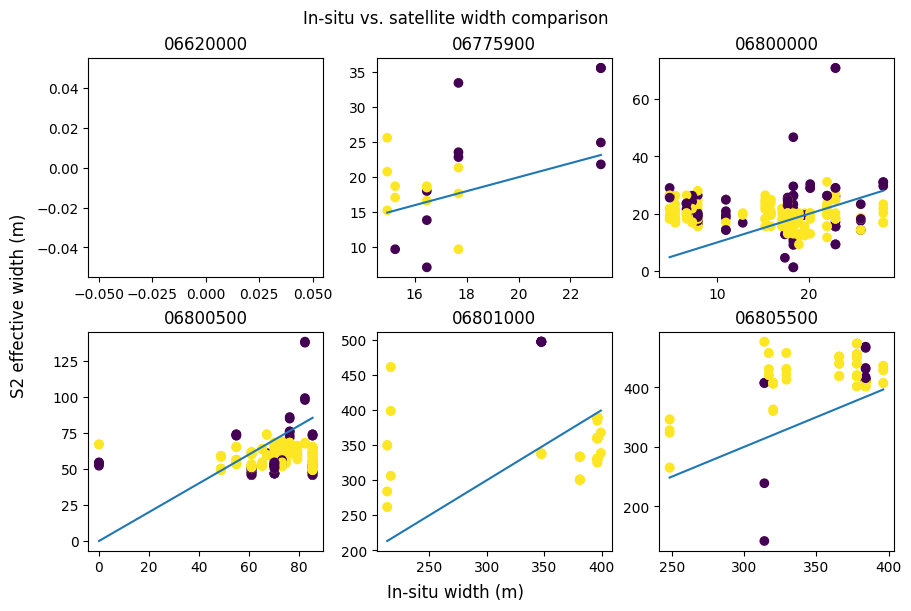

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in alldata.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.sat_width_m, c=df.like)
    unity = np.linspace(df.gage_width_m.min(), df.gage_width_m.max())
    ax.plot(unity, unity)
    ax.set_title(g)
    p += 1

fig.supxlabel('In-situ width (m)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('In-situ vs. satellite width comparison')

In [135]:
month_avgs = t.groupby(['site_no', 'month']).agg(
    mean_Q = ('Q_cms', 'mean'),
    mean_w = ('sat_width_m', 'mean'),
    median_Q = ('Q_cms', 'median'),
    median_w = ('sat_width_m', 'median'),
    sd_Q = ('Q_cms', 'std'),
    sd_w = ('sat_width_m', 'std')
)

In [136]:
month_avgs

mean_Q     mean_w   median_Q   median_w      sd_Q      sd_w
site_no  month                                                                
06620000 5      22.798408  28.071538  22.798408  28.071538  7.754868  9.547897
         6      19.241913  40.508296  19.241913  40.508296       NaN       NaN
         7      20.800536  31.269562  20.800536  31.269562       NaN       NaN
         8       1.840592  29.492882   1.840592  29.492882  0.034065  4.522688
         9       2.343603  25.228851   2.343603  25.228851  0.637222  1.507563
...                   ...        ...        ...        ...       ...       ...
06800000 8       1.413635  21.662565   1.031525  21.581310  1.145038  2.574350
         9       0.823965  23.370386   0.386822  22.255726  1.038794  4.766368
         10      0.927910  20.452696   0.382571  19.558062  1.098767  5.518867
         11      1.007579  18.649474   0.677293  17.197606  0.848999  7.198264
         12      1.442564  20.416410   0.886998  20.232478  1.232476  2.374698

[295 rows x 6 columns]

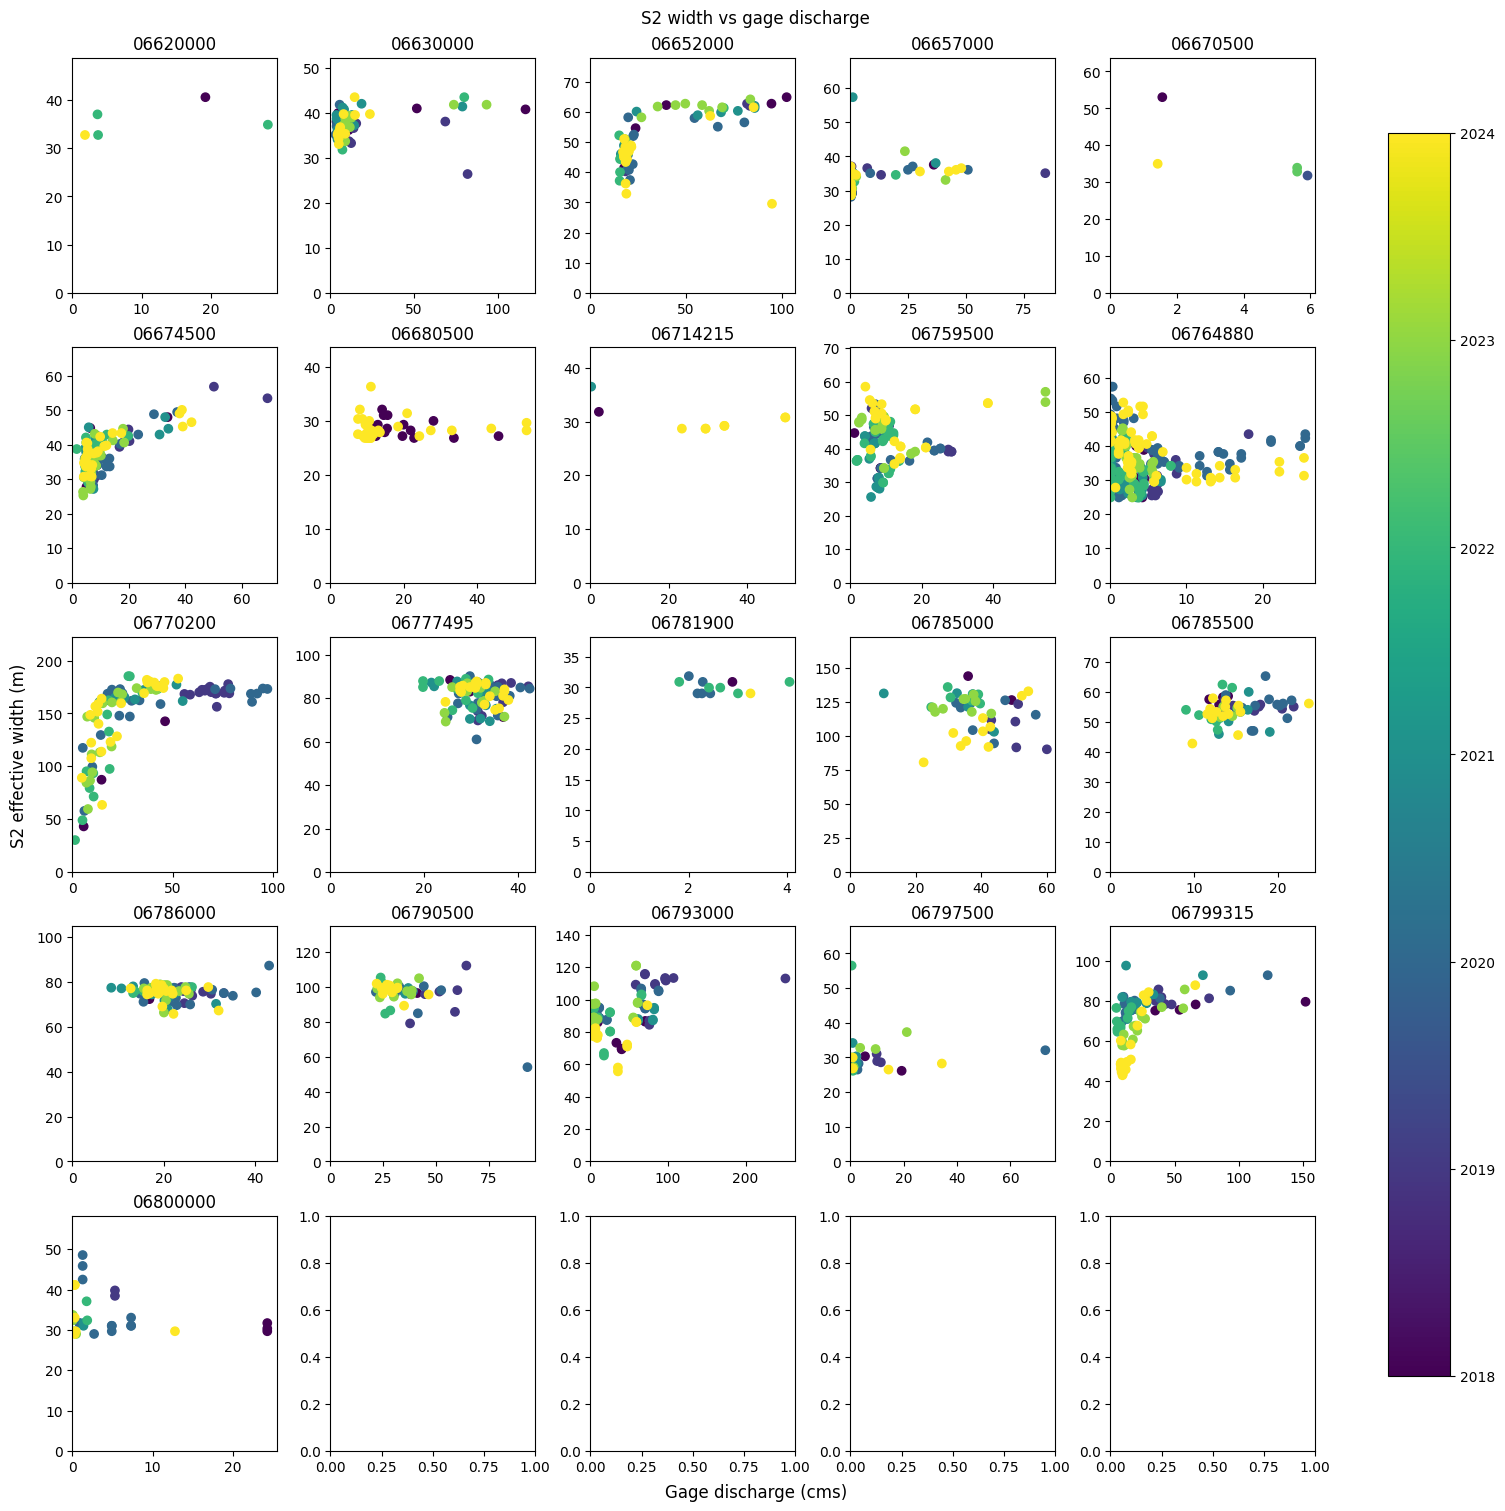

In [233]:
t = alldata.loc[alldata.fraction_cloud < 0.2]
t = t.loc[t.fraction_snow < 0.2]
t = t.loc[t.Q_cms > 0]
t = t.loc[(t.n_cloud - t.n_cloudriver / t.n_valid) < 0.4]
t = t.loc[t.fraction_edgeriver < 0.3]
t = t.loc[t.Q_cd == 'A']

t = t.loc[t.n_edge < t.n_river]




t = t.reset_index()
t.date = pd.to_datetime(t.date)
t['month'] = t.date.dt.month
t['year'] = t.date.dt.year

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15), constrained_layout=True)
p = 0
for g, df in t.groupby('site_no'):


    ax = axs.flatten()[p]
    # df1 = df.loc[df.Q_cd == 'A']
    # df2 = df.loc[df.Q_cd != 'A']
    dat1 = ax.scatter(df.Q_cms, df.sat_width_m, c=df.year)
    # dat2 = ax.scatter(df.median_Q, df.median_w, c='blue')
    # dat2 = ax.scatter(df2.Q_cms, df2.sat_width_m, c='red')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0, top=1.2 * max(df.sat_width_m))
    ax.set_title(g)
    p += 1

fig.supxlabel('Gage discharge (cms)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('S2 width vs gage discharge')

fig.colorbar(dat1, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0       06620000
1       06620000
2       06620000
3       06620000
4       06620000
          ...   
1538    06800000
1539    06800000
1540    06800000
1541    06800000
1542    06800000
Name: site_no, Length: 1543, dtype: object

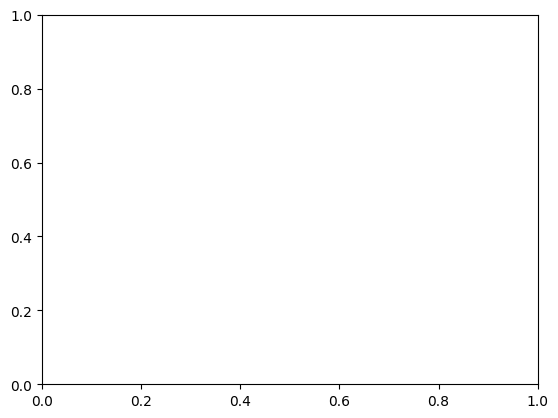

In [234]:
gage_pts.loc[gage_pts.site_no == '06764880']

,site_no,iindex,riv_length
26,06764880,225467,172.516752


In [216]:
gage_list[n]

'06711565'

In [235]:
n = 16 # width varies little with discharge, stage varies a lot with discharge
n = 19 # river at low width is confined to low-flow channel
n = 20 # obscured by bridge and trees
n=26
g = alldata.loc[gage_list[n]]
g = g.loc[g.fraction_snow < 0.2]
g = g.loc[g.Q_cms > 0]
g = g.loc[(g.n_cloud - g.n_cloudriver / g.n_valid) < 0.4]
g = g.loc[g.fraction_edgeriver < 0.3]
g = g.loc[g.Q_cd == 'A']
g = g.reset_index()
g = g.loc[g.n_river > g.n_edgeriver]
g['year'] = g.date.apply(lambda x: x.year)

custom_info = ['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']

fig = go.Figure(
    go.Scatter(
        x=g.Q_cms,
        y=g.sat_width_m,
        mode='markers',
        marker=dict(
            color=g.year,
            colorscale='viridis'),
        customdata = g[['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']],
        hovertemplate='<b>X Value:</b> %{x}<br>' +
                      '<b>Y Value:</b> %{y}<br>' +
                      '<b>fraction_cloud:</b> %{customdata[0]}<br>' +
                      '<b>fraction_snow:</b> %{customdata[1]}<br>' +
                      '<b>n_edge:</b> %{customdata[2]}<br>' +
                      '<b>n_edgeriver:</b> %{customdata[3]}<br>' +
                      '<b>n_valid:</b> %{customdata[4]}<br>' +
                      '<b>n_cloud:</b> %{customdata[5]}<br>' +
                      '<b>n_cloudriver:</b> %{customdata[6]}<br>' +
                      '<b>n_river:</b> %{customdata[7]}<br>' +
                      '<b>img_id:</b> %{customdata[8]}<br>' +
                      '<b>iindex:</b> %{customdata[9]}<br>'
    )
)

fig.update_layout(
    title=gage_list[n],
    xaxis_title=dict(text='Discharge (cms)'),
    yaxis_title=dict(text='Width (m)'),
    yaxis=dict(range=[0, max(g.sat_width_m) + (max(g.sat_width_m) / 5)]),
    scene=dict(aspectmode='auto')
)
fig.show()

In [183]:
fig = go.Figure(
    go.Scatter(
        y=g.d_m,
        x=g.sat_width_m,
        mode='markers',
        marker=dict(
            color=g.year,
            colorscale='viridis'),
        customdata = g[['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']],
        hovertemplate='<b>X Value:</b> %{x}<br>' +
                      '<b>Y Value:</b> %{y}<br>' +
                      '<b>fraction_cloud:</b> %{customdata[0]}<br>' +
                      '<b>fraction_snow:</b> %{customdata[1]}<br>' +
                      '<b>n_edge:</b> %{customdata[2]}<br>' +
                      '<b>n_edgeriver:</b> %{customdata[3]}<br>' +
                      '<b>n_valid:</b> %{customdata[4]}<br>' +
                      '<b>n_cloud:</b> %{customdata[5]}<br>' +
                      '<b>n_cloudriver:</b> %{customdata[6]}<br>' +
                      '<b>n_river:</b> %{customdata[7]}<br>' +
                      '<b>img_id:</b> %{customdata[8]}<br>' +
                      '<b>iindex:</b> %{customdata[9]}<br>'
    )
)


fig.update_layout(
    yaxis_title=dict(text='Stage (m)'),
    xaxis_title=dict(text='Width (m)'))
fig.show()

In [184]:
fig = go.Figure(
    go.Scatter(
        x=g.Q_cms,
        y=g.d_m,
        mode='markers',
        marker=dict(
            color=g.year,
            colorscale='viridis'),
        customdata = g[['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']],
        hovertemplate='<b>X Value:</b> %{x}<br>' +
                      '<b>Y Value:</b> %{y}<br>' +
                      '<b>fraction_cloud:</b> %{customdata[0]}<br>' +
                      '<b>fraction_snow:</b> %{customdata[1]}<br>' +
                      '<b>n_edge:</b> %{customdata[2]}<br>' +
                      '<b>n_edgeriver:</b> %{customdata[3]}<br>' +
                      '<b>n_valid:</b> %{customdata[4]}<br>' +
                      '<b>n_cloud:</b> %{customdata[5]}<br>' +
                      '<b>n_cloudriver:</b> %{customdata[6]}<br>' +
                      '<b>n_river:</b> %{customdata[7]}<br>' +
                      '<b>img_id:</b> %{customdata[8]}<br>' +
                      '<b>iindex:</b> %{customdata[9]}<br>'
    )
)


fig.update_layout(
    xaxis_title=dict(text='Discharge (cms)'),
    yaxis_title=dict(text='Stage (m)'))
fig.show()

In [148]:
gage_list[n]

'06786000'